### Problem Statement:

### Import Dependencies

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image
from pathlib import Path
from collections import Counter
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping

### Load Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/Dataset/pandas_bears.zip"

Archive:  /content/drive/MyDrive/Dataset/pandas_bears.zip
   creating: pandas_bears/
   creating: pandas_bears/test/
   creating: pandas_bears/test/bear/
  inflating: pandas_bears/test/bear/291.jpeg  
  inflating: pandas_bears/test/bear/292.jpeg  
  inflating: pandas_bears/test/bear/293.jpeg  
  inflating: pandas_bears/test/bear/294.jpeg  
  inflating: pandas_bears/test/bear/295.jpeg  
  inflating: pandas_bears/test/bear/296.jpeg  
  inflating: pandas_bears/test/bear/297.jpeg  
  inflating: pandas_bears/test/bear/298.jpeg  
  inflating: pandas_bears/test/bear/299.jpeg  
  inflating: pandas_bears/test/bear/300.jpeg  
   creating: pandas_bears/test/panda/
  inflating: pandas_bears/test/panda/291.jpeg  
  inflating: pandas_bears/test/panda/292.jpeg  
  inflating: pandas_bears/test/panda/293.jpeg  
  inflating: pandas_bears/test/panda/294.jpeg  
  inflating: pandas_bears/test/panda/295.jpeg  
  inflating: pandas_bears/test/panda/296.jpeg  
  inflating: pandas_bears/test/panda/297.jpeg  
  

In [4]:
data_dir = Path("/content/pandas_bears")
os.listdir(data_dir)

['test', 'train']

In [5]:
train_dir = Path("/content/pandas_bears/train")
test_dir = Path("/content/pandas_bears/test")
print(f"Train Directory Total Classes: {len(os.listdir(train_dir))}")
print(f"Test Directory Total Classes: {len(os.listdir(test_dir))}")

Train Directory Total Classes: 2
Test Directory Total Classes: 2


### Visualize Images

In [6]:
def display_image(image_path: Path):
    image = imread(image_path)
    return plt.imshow(image)

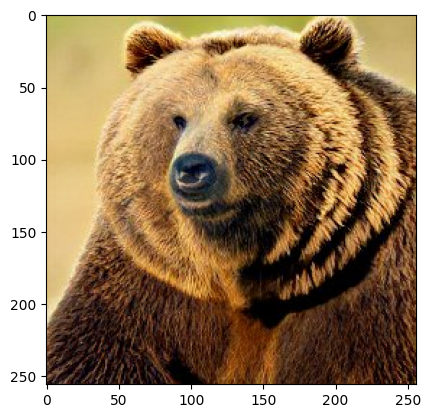

In [7]:
image_path = '/content/pandas_bears/train/bear/1.jpeg'
display_image(image_path=Path(image_path))

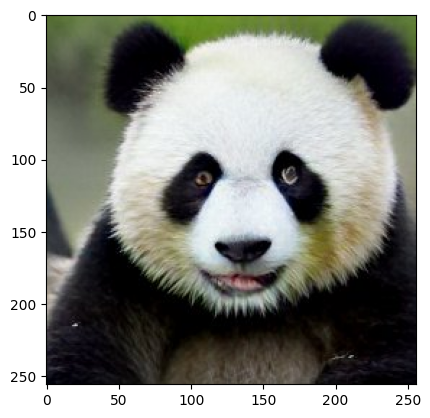

In [8]:
image_path = '/content/pandas_bears/train/panda/1.jpeg'
display_image(image_path=Path(image_path))

### Image Information

In [9]:
def image_info(data_dir):
    total_size = 0  # To accumulate total image size in bytes
    total_width = 0  # Sum of all image widths
    total_height = 0  # Sum of all image heights
    image_count = 0   # Count of total images
    color_modes = Counter()  # To store the count of different image modes

    # Traverse through all directories and subdirectories
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
                file_path = os.path.join(root, file)

                # Get the image size in bytes
                total_size += os.path.getsize(file_path)

                # Open the image to get its dimensions and mode
                with Image.open(file_path) as img:
                    width, height = img.size
                    total_width += width
                    total_height += height

                    # Track the color mode (e.g., 'RGB', 'RGBA', 'L', etc.)
                    color_modes[img.mode] += 1

                image_count += 1

    if image_count == 0:
        print("No images found in the given directory.")
        return

    # Calculate average size and dimensions
    avg_size = total_size / image_count
    avg_width = total_width / image_count
    avg_height = total_height / image_count

    # Print the results
    print(f"Total Images: {image_count}")
    print(f"Average Image Size: {avg_size:.2f} bytes")
    print(f"Average Image Dimensions: {avg_width:.2f} x {avg_height:.2f} pixels")

    # Print the color channel information
    print("\nImage Color Channels (Modes):")
    for mode, count in color_modes.items():
        print(f"{mode}: {count} images")

In [10]:
image_info(data_dir=train_dir)

Total Images: 580
Average Image Size: 20418.84 bytes
Average Image Dimensions: 256.00 x 256.00 pixels

Image Color Channels (Modes):
RGB: 580 images


In [11]:
image_info(data_dir=test_dir)

Total Images: 20
Average Image Size: 20336.20 bytes
Average Image Dimensions: 256.00 x 256.00 pixels

Image Color Channels (Modes):
RGB: 20 images


### Data Augmentation

In [12]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32

In [13]:
image_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [14]:
train_datagen = image_datagen.flow_from_directory(directory=train_dir,
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='binary',
                                                  color_mode='rgb')

Found 580 images belonging to 2 classes.


In [15]:
test_datagen = image_datagen.flow_from_directory(directory=test_dir,
                                                 target_size=IMAGE_SIZE,
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='binary',
                                                 color_mode='rgb')

Found 20 images belonging to 2 classes.


### Load VGG19 Model (without top layers)

In [16]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# add custom top layers
x = Flatten()(vgg19.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(units=1, activation='sigmoid')(x)

model = Model(inputs=vgg19.input, outputs=output)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [17]:
for layer in vgg19.layers:
    layer.trainable = False

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 24,218,945 (92.39 MB)

 Trainable params: 4,194,561 (16.00 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

### Training Model

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_datagen, validation_data=test_datagen, epochs=10, callbacks=[early_stop])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.7013 - loss: 1.4689 - val_accuracy: 1.0000 - val_loss: 8.3068e-05
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 411ms/step - accuracy: 0.9880 - loss: 0.0456 - val_accuracy: 1.0000 - val_loss: 1.8736e-05
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 438ms/step - accuracy: 0.9940 - loss: 0.0120 - val_accuracy: 1.0000 - val_loss: 8.4031e-06
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 451ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 6.3295e-06
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 1.2335e-06
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 444ms/step - accuracy: 1.0000 - loss: 4.9456e-04 - val_accuracy: 1.0000 - val_loss: 2.5906e-06
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 419ms/step - accuracy: 0.9943 - loss: 0.0067 - val_accuracy: 1.0000 - val_loss: 1.4226e-06
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 377ms/step - accuracy: 1.0000 - loss:

### Evaluating Model

In [19]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax1.set_title('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Val Loss')
    ax2.set_title('Loss')
    ax2.legend()
    plt.show()

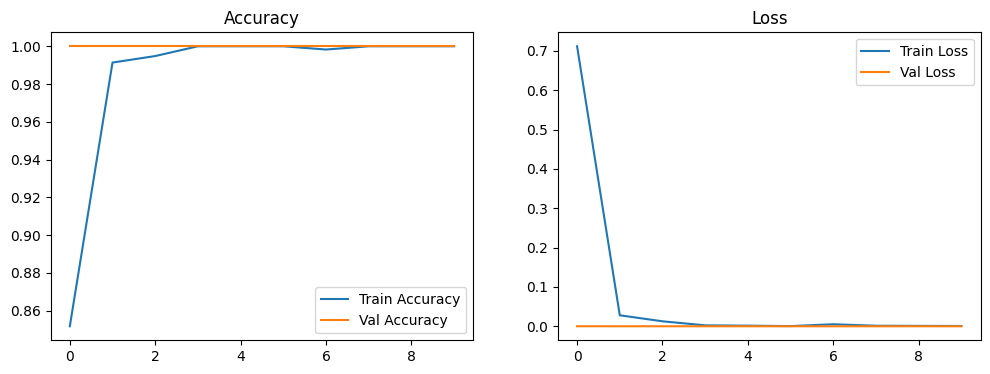

In [20]:
plot_history(history)

### Saving Model

In [21]:
model.save('bears_pandas_vgg19.h5')